In [ ]:
# Import  libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO  # For reading CSV data
from tqdm import tqdm
from geopy.geocoders import Nominatim  # For geocoding
import folium  # For interactive mapping
from ipywidgets import widgets  # For dropdown filtering
from IPython.display import display, clear_output
import ipywidgets as widgets
import plotly.express as px

# **1. Data Import**

In [ ]:
# Data Cleaning
def organize_subjective_wellbeing_data(dataframe):
    """
    Process and organize the 'Subjective wellbeing' dataset:
    - Filters data for 'Subjective wellbeing' topics.
    - Drops unnecessary columns.
    - Adds a 'Category' column based on 'respondent_group' for classification.
    - Reorganizes and renames columns for clarity.

    Args:
        dataframe (pd.DataFrame): Input dataset containing raw data.

    Returns:
        pd.DataFrame: Cleaned and structured DataFrame.
    """
    # Step 1: Filter for rows where the topic is 'Subjective wellbeing'
    filtered_df = dataframe[dataframe['topic'] == 'Subjective wellbeing']

    # Step 2: Drop unnecessary columns (if they exist)
    drop_columns = ['indicator', 'topic', 'type', 'response', 'format', 'sample_size']
    filtered_df = filtered_df.drop(columns=[col for col in drop_columns if col in filtered_df.columns], errors='ignore')

    # Step 3: Add a 'Category' column based on respondent grouping
    def categorize_respondent_group(row):
        if row.get('respondent_group') in ['Male', 'Female']:
            return 'Gender'
        elif row.get('respondent_group') in ['18-24 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', '65+ years']:
            return 'Age Group'
        elif row.get('respondent_group') in ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']:
            return 'Age Group'
        else:
            return 'Suburb'

    filtered_df['Category'] = filtered_df.apply(categorize_respondent_group, axis=1)

    # Step 4: Reorganize and rename columns for clarity
    reorganized_df = filtered_df[['description', 'Category', 'respondent_group', 'year', 'result']]
    reorganized_df = reorganized_df.rename(columns={
        'description': 'Subtopics',
        'respondent_group': 'Subcategory',
        'result': 'Percentage'
    })

    # Adjust the index to start from 1
    reorganized_df.index += 1

    # Renaming colums as 2020 dataset is different
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('18-24', '18-24 years')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('24-34', '24-34 years')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('25-34', '25-34 years')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('35-44', '35-44 years')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('45-54', '45-54 years')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('55-64', '55-64 years')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('65+', '65+ years')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('Kensington/ Flemingon 3031', 'Kensington / Flemington 3031')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('South Yarra 3141 / Melbourne (St Kilda Road) 3004', 'South Yarra 3141 / Melbourne/St Kilda Road 3004')
    reorganized_df['Subcategory'] = reorganized_df['Subcategory'].replace('Southbank/ South Wharf 3006', 'South Wharf / Southbank 3006')

    return reorganized_df

In [ ]:
def fetch_and_combine_datasets(dataset_ids, base_url):
    """
    Fetch and combine datasets from the specified URLs, standardizing schema across years.

    Args:
        dataset_ids (list): List of dataset IDs to fetch.
        base_url (str): Base URL for accessing the datasets.

    Returns:
        pd.DataFrame: Combined DataFrame of all fetched datasets with standardized schema.
    """
    dataframes = []

    for dataset_id in dataset_ids:
        url = f'{base_url}{dataset_id}/exports/csv'
        try:
            response = requests.get(url)
            response.raise_for_status()

            # Load CSV content with semicolon as the delimiter
            df = pd.read_csv(StringIO(response.content.decode('utf-8')), delimiter=';', on_bad_lines='skip')

            # Standardize column names: rename `respondent_group0` to `respondent_group`
            if 'respondent_group0' in df.columns:
                df.rename(columns={'respondent_group0': 'respondent_group'}, inplace=True)

            dataframes.append(df)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching dataset {dataset_id}: {e}")
            continue

    # Combine all datasets into a single DataFrame
    combined_df = pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

    return combined_df

In [ ]:
# Load datasets year by year
BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
DATASET_IDS = [
    'social-indicators-for-city-of-melbourne-residents-2023',
    'social-indicators-for-city-of-melbourne-residents-2022',
    'social-indicators-for-city-of-melbourne-residents-2020',
    'social-indicators-for-city-of-melbourne-residents-2019',
    'social-indicators-for-city-of-melbourne-residents-2018',
    'social-indicators-for-city-of-melbourne-residents-2021'
]

In [ ]:
if __name__ == "__main__":
    # Fetch datasets
    combined_data = fetch_and_combine_datasets(DATASET_IDS, BASE_URL)

    if not combined_data.empty:
        # Process and organize the data
        processed_data = organize_subjective_wellbeing_data(combined_data)

        # Display the processed data
        if not processed_data.empty:
            display(processed_data)
        else:
            print("Processed data is empty. Please check the input.")
    else:
        print("No datasets were fetched. Please check the URLs or network connection.")


,Subtopics,Category,Subcategory,year,Percentage
142,Satisfaction with standard of living,Age Group,35-44 years,2023,73.4
143,Satisfaction with standard of living,Age Group,55-64 years,2023,79.4
144,Satisfaction with standard of living,Age Group,65+ years,2023,85.7
145,Satisfaction with standard of living,Gender,Female,2023,74.9
146,Satisfaction with standard of living,Suburb,Carlton 3053,2023,68.7
...,...,...,...,...,...
3907,Satisfaction with future security,Age Group,35-44 years,2021,68.0
3908,Satisfaction with future security,Age Group,65+ years,2021,82.3
3909,Satisfaction with future security,Gender,Female,2021,61.5
3910,Satisfaction with future security,Suburb,Melbourne 3000,2021,60.7


# **3. Organizing Data for Subtopics (2018–2023)**

In [ ]:
# Organize Data for Each Subtopic from 2018–2023 and display

def organize_data_by_subtopic(dataframe):
  """
  Organizes the dataframe to display data for each subtopic from 2018 to 2023.

  Args:
      dataframe (pd.DataFrame): The input dataframe.

  Returns:
      dict: A dictionary where keys are subtopics and values are dataframes
            containing data for that subtopic from 2018 to 2023.
  """
  subtopic_data = {}
  for subtopic in dataframe['Subtopics'].unique():
    subtopic_df = dataframe[dataframe['Subtopics'] == subtopic]
    subtopic_data[subtopic] = subtopic_df
  return subtopic_data


if not processed_data.empty:
  subtopic_data_dict = organize_data_by_subtopic(processed_data)

  for subtopic, subtopic_df in subtopic_data_dict.items():
    print(f"\nData for Subtopic: {subtopic}")
    display(subtopic_df)
else:
  print("Processed data is empty. Please check the input.")


Data for Subtopic: Satisfaction with standard of living


,Subtopics,Category,Subcategory,year,Percentage
142,Satisfaction with standard of living,Age Group,35-44 years,2023,73.4
143,Satisfaction with standard of living,Age Group,55-64 years,2023,79.4
144,Satisfaction with standard of living,Age Group,65+ years,2023,85.7
145,Satisfaction with standard of living,Gender,Female,2023,74.9
146,Satisfaction with standard of living,Suburb,Carlton 3053,2023,68.7
...,...,...,...,...,...
3876,Satisfaction with standard of living,Age Group,55-64 years,2021,80.7
3877,Satisfaction with standard of living,Gender,Female,2021,75.9
3878,Satisfaction with standard of living,Gender,Male,2021,76.3
3879,Satisfaction with standard of living,Suburb,East Melbourne 3002,2021,80.9



Data for Subtopic: Satisfaction with health


,Subtopics,Category,Subcategory,year,Percentage
150,Satisfaction with health,Age Group,35-44 years,2023,73.8
151,Satisfaction with health,Age Group,45-54 years,2023,70.5
152,Satisfaction with health,Gender,Female,2023,71.5
153,Satisfaction with health,Suburb,City of Melbourne,2023,72.9
154,Satisfaction with health,Suburb,Docklands 3008,2023,69.9
...,...,...,...,...,...
3883,Satisfaction with health,Suburb,Carlton 3053,2021,72.4
3884,Satisfaction with health,Suburb,Docklands 3008,2021,71.6
3885,Satisfaction with health,Suburb,North Melbourne 3051 / West Melbourne 3003,2021,70.6
3886,Satisfaction with health,Suburb,South Wharf / Southbank 3006,2021,73.7



Data for Subtopic: Satisfaction with currently achieving in life


,Subtopics,Category,Subcategory,year,Percentage
157,Satisfaction with currently achieving in life,Age Group,35-44 years,2023,70.9
158,Satisfaction with currently achieving in life,Age Group,55-64 years,2023,69.7
159,Satisfaction with currently achieving in life,Age Group,65+ years,2023,79.4
160,Satisfaction with currently achieving in life,Gender,Female,2023,69.5
161,Satisfaction with currently achieving in life,Suburb,Carlton 3053,2023,64.9
...,...,...,...,...,...
3667,Satisfaction with currently achieving in life,Suburb,South Yarra 3141 / Melbourne/St Kilda Road 3004,2021,72.5
3888,Satisfaction with currently achieving in life,Age Group,25-34 years,2021,66.7
3889,Satisfaction with currently achieving in life,Age Group,45-54 years,2021,65.6
3890,Satisfaction with currently achieving in life,Age Group,55-64 years,2021,60.7



Data for Subtopic: Satisfaction with personal relationships


,Subtopics,Category,Subcategory,year,Percentage
162,Satisfaction with personal relationships,Age Group,18-24 years,2023,69.8
163,Satisfaction with personal relationships,Age Group,45-54 years,2023,73.6
164,Satisfaction with personal relationships,Age Group,65+ years,2023,83.7
165,Satisfaction with personal relationships,Gender,Female,2023,73.5
166,Satisfaction with personal relationships,Gender,Male,2023,73.8
...,...,...,...,...,...
3894,Satisfaction with personal relationships,Suburb,City of Melbourne,2021,71.8
3895,Satisfaction with personal relationships,Suburb,Docklands 3008,2021,67.5
3896,Satisfaction with personal relationships,Suburb,East Melbourne 3002,2021,77.6
3897,Satisfaction with personal relationships,Suburb,North Melbourne 3051 / West Melbourne 3003,2021,71.2



Data for Subtopic: Satisfaction with how safe you feel


,Subtopics,Category,Subcategory,year,Percentage
171,Satisfaction with how safe you feel,Age Group,55-64 years,2023,79.0
172,Satisfaction with how safe you feel,Suburb,City of Melbourne,2023,79.1
173,Satisfaction with how safe you feel,Suburb,Docklands 3008,2023,79.9
174,Satisfaction with how safe you feel,Suburb,East Melbourne 3002,2023,85.0
175,Satisfaction with how safe you feel,Suburb,Kensington / Flemington 3031,2023,81.6
...,...,...,...,...,...
3676,Satisfaction with how safe you feel,Suburb,South Wharf / Southbank 3006,2021,80.2
3899,Satisfaction with how safe you feel,Age Group,18-24 years,2021,77.5
3900,Satisfaction with how safe you feel,Age Group,65+ years,2021,89.2
3901,Satisfaction with how safe you feel,Suburb,East Melbourne 3002,2021,79.2



Data for Subtopic: Satisfaction with feeling part of your community


,Subtopics,Category,Subcategory,year,Percentage
177,Satisfaction with feeling part of your community,Age Group,65+ years,2023,73.0
178,Satisfaction with feeling part of your community,Gender,Female,2023,63.8
179,Satisfaction with feeling part of your community,Gender,Male,2023,64.8
180,Satisfaction with feeling part of your community,Suburb,Docklands 3008,2023,65.1
181,Satisfaction with feeling part of your community,Suburb,East Melbourne 3002,2023,70.1
...,...,...,...,...,...
3685,Satisfaction with feeling part of your community,Suburb,North Melbourne 3051 / West Melbourne 3003,2021,63.5
3903,Satisfaction with feeling part of your community,Age Group,55-64 years,2021,64.8
3904,Satisfaction with feeling part of your community,Suburb,Kensington / Flemington 3031,2021,65.5
3905,Satisfaction with feeling part of your community,Suburb,Parkville 3052,2021,65.8



Data for Subtopic: Satisfaction with future security


,Subtopics,Category,Subcategory,year,Percentage
185,Satisfaction with future security,Suburb,Carlton 3053,2023,62.5
186,Satisfaction with future security,Suburb,Kensington / Flemington 3031,2023,68.1
187,Satisfaction with future security,Suburb,North Melbourne 3051 / West Melbourne 3003,2023,68.9
188,Satisfaction with future security,Suburb,Parkville 3052,2023,66.3
189,Satisfaction with future security,Suburb,South Yarra 3141 / Melbourne/St Kilda Road 3004,2023,66.1
...,...,...,...,...,...
3907,Satisfaction with future security,Age Group,35-44 years,2021,68.0
3908,Satisfaction with future security,Age Group,65+ years,2021,82.3
3909,Satisfaction with future security,Gender,Female,2021,61.5
3910,Satisfaction with future security,Suburb,Melbourne 3000,2021,60.7


### **Visualizing subtopics**

In [ ]:
#  three side by side graphs for age group, suburb and gender with dropdown widget for subtopic and year

def create_side_by_side_plots(dataframe, subtopic, year):
    """
    Creates three side-by-side bar plots for age group, suburb, and gender.
    """

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    categories = ['Age Group', 'Suburb', 'Gender']

    for i, category in enumerate(categories):
        # Filter data for the selected subtopic, category, and year
        filtered_df = dataframe[(dataframe['Subtopics'] == subtopic) &
                                 (dataframe['Category'] == category) &
                                 (dataframe['year'] == year)]

        if filtered_df.empty:
          axes[i].set_title(f'No Data for {category}')
          continue

        # Group by subcategory and calculate the mean percentage
        grouped_df = filtered_df.groupby('Subcategory')['Percentage'].mean()

        # Create the bar plot
        grouped_df.plot(kind='bar', ax=axes[i])
        axes[i].set_xlabel('Subcategory')
        axes[i].set_ylabel('Percentage')
        axes[i].set_title(f'{category} for "{subtopic}" in {year}')
        axes[i].tick_params(axis='x', rotation=45, labelsize=8) # Adjust label size if needed

    plt.tight_layout()
    plt.show()


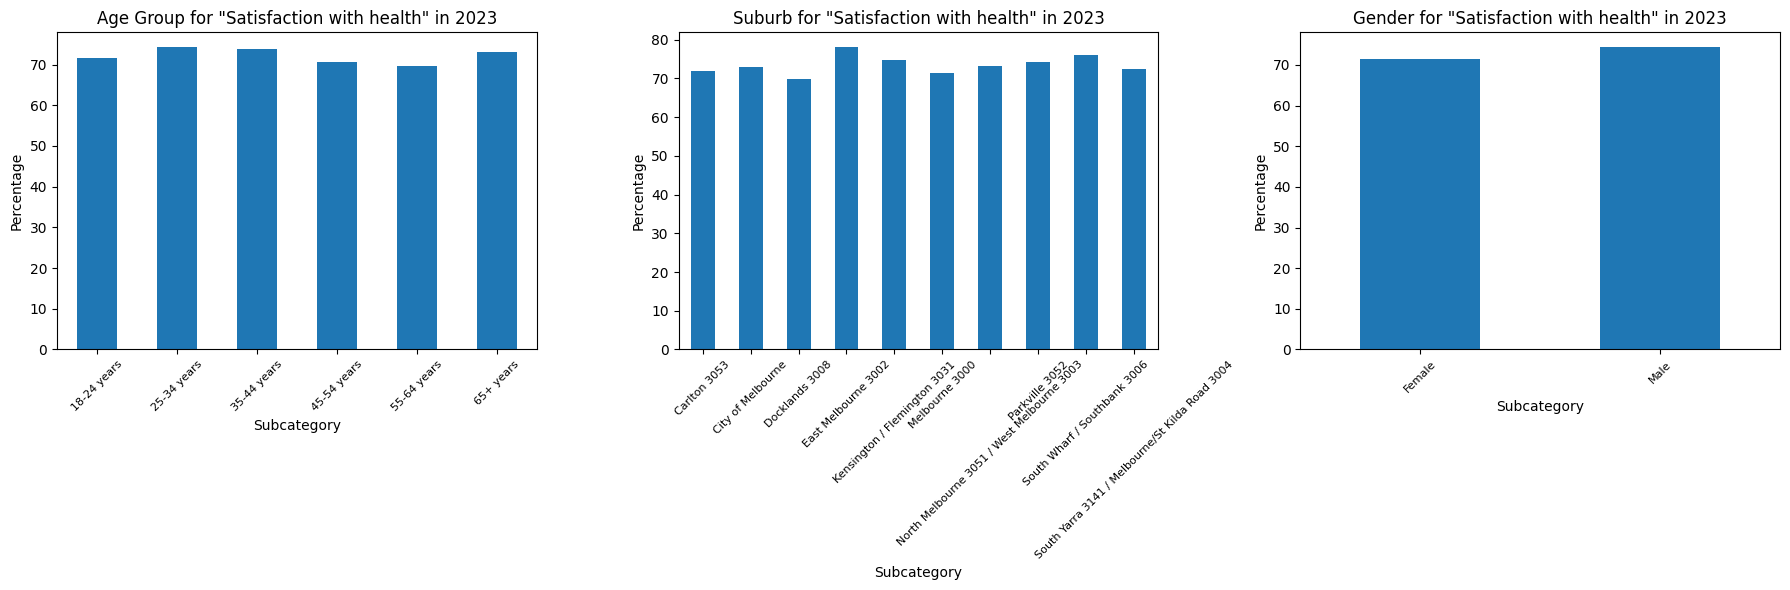

In [ ]:
# Example usage
create_side_by_side_plots(processed_data, "Satisfaction with health", 2023)

In [ ]:
# dropdown widget

# Create widgets for subtopic and year selection
subtopic_dropdown = widgets.Dropdown(
    options=processed_data['Subtopics'].unique().tolist(),
    value=processed_data['Subtopics'].unique().tolist()[0],
    description='Subtopic:',
    disabled=False,
)

year_dropdown = widgets.Dropdown(
    options=processed_data['year'].unique().tolist(),
    value=processed_data['year'].unique().tolist()[0],
    description='Year:',
    disabled=False,
)


# Create an output widget to display the plots
output = widgets.Output()

# Define a function to handle widget changes
def update_plot(change):
  with output:
    clear_output(wait=True) # Clear previous plot
    create_side_by_side_plots(processed_data, subtopic_dropdown.value, year_dropdown.value)


# Observe widget changes
subtopic_dropdown.observe(update_plot, names='value')
year_dropdown.observe(update_plot, names='value')

# Display widgets and output
display(subtopic_dropdown, year_dropdown, output)

# Initial plot
with output:
  create_side_by_side_plots(processed_data, subtopic_dropdown.value, year_dropdown.value)

Dropdown(description='Subtopic:', options=('Satisfaction with standard of living', 'Satisfaction with health',…

Dropdown(description='Year:', options=(2023, 2022, 2020, 2019, 2018, 2021), value=2023)

Output()

In [ ]:
# prompt: Tree Map: Hierarchical percentage across suburbs

def create_treemap(dataframe, subtopic, year):
    """
    Creates an interactive treemap visualization.
    """

    # Filter data for the selected subtopic and year
    filtered_df = dataframe[(dataframe['Subtopics'] == subtopic) & (dataframe['year'] == year)]

    if filtered_df.empty:
        print(f"No data found for subtopic '{subtopic}' in year {year}.")
        return

    # Create the treemap
    fig = px.treemap(filtered_df,
                     path=['Category', 'Subcategory'],  # Define hierarchical levels
                     values='Percentage',
                     color='Percentage',
                     hover_data=['Percentage'],
                     title=f'Hierarchical Percentage for "{subtopic}" in {year}')
    fig.show()

# Example usage
create_treemap(processed_data, "Satisfaction with health", 2023)

# Integrate with the existing widgets
def update_treemap(change):
    with output:
        clear_output(wait=True)
        create_treemap(processed_data, subtopic_dropdown.value, year_dropdown.value)

# Observe widget changes for the treemap
subtopic_dropdown.observe(update_treemap, names='value')
year_dropdown.observe(update_treemap, names='value')

# Initial treemap
with output:
    create_treemap(processed_data, subtopic_dropdown.value, year_dropdown.value)

In [ ]:
# prompt: Radial Chart: Multi-dimensional satisfaction for subtopics

import plotly.graph_objects as go

def create_radial_chart(dataframe, year, subtopic):
    """
    Creates a radial chart (radar chart) to visualize multi-dimensional satisfaction for subtopics.
    """

    filtered_df = dataframe[(dataframe['year'] == year) & (dataframe['Subtopics'] == subtopic)]

    if filtered_df.empty:
        print(f"No data found for year {year} and subtopic '{subtopic}'.")
        return

    categories = filtered_df['Subcategory'].tolist()
    values = filtered_df['Percentage'].tolist()

    fig = go.Figure(data=go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name=subtopic
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]  # Adjust range as needed
            )),
        title=f'Satisfaction with "{subtopic}" in {year}',
        showlegend=True
    )
    fig.show()

# Example usage:
create_radial_chart(processed_data, 2023, "Satisfaction with health")


# Interactive radial chart with widgets

# Create widgets for year and subtopic selection
year_dropdown_radial = widgets.Dropdown(
    options=processed_data['year'].unique().tolist(),
    value=processed_data['year'].unique().tolist()[0],
    description='Year:',
    disabled=False,
)

subtopic_dropdown_radial = widgets.Dropdown(
    options=processed_data['Subtopics'].unique().tolist(),
    value=processed_data['Subtopics'].unique().tolist()[0],
    description='Subtopic:',
    disabled=False,
)

output_radial = widgets.Output()

def update_radial_chart(change):
    with output_radial:
        clear_output(wait=True)
        create_radial_chart(processed_data, year_dropdown_radial.value, subtopic_dropdown_radial.value)

year_dropdown_radial.observe(update_radial_chart, names='value')
subtopic_dropdown_radial.observe(update_radial_chart, names='value')


display(year_dropdown_radial, subtopic_dropdown_radial, output_radial)

with output_radial:
    create_radial_chart(processed_data, year_dropdown_radial.value, subtopic_dropdown_radial.value)

Dropdown(description='Year:', options=(2023, 2022, 2020, 2019, 2018, 2021), value=2023)

Dropdown(description='Subtopic:', options=('Satisfaction with standard of living', 'Satisfaction with health',…

Output()

# **4. Yearly Analysis**

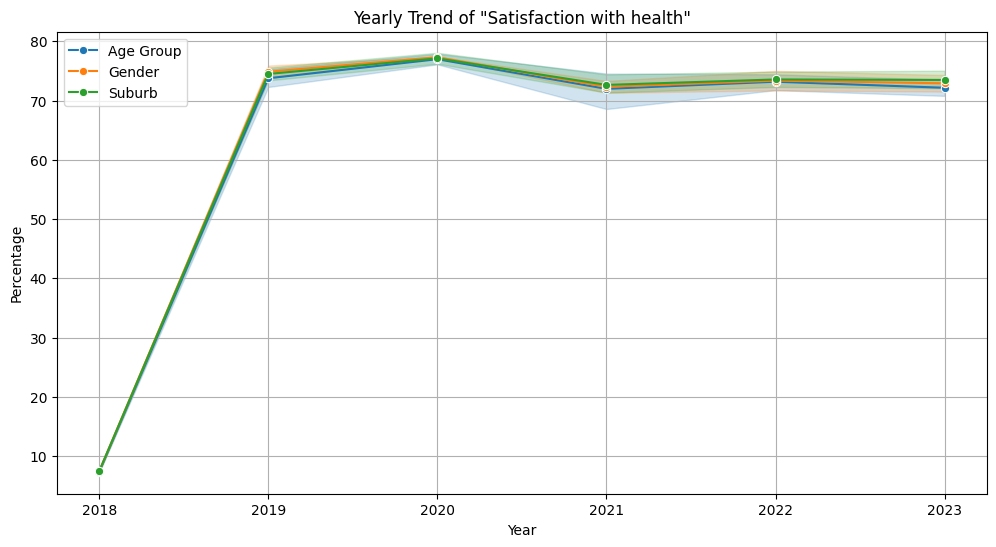

Dropdown(description='Subtopic:', options=('Satisfaction with standard of living', 'Satisfaction with health',…

Output()

In [ ]:
# prompt: Comparing satisfaction trends year by year for subtopics

def plot_yearly_trends(dataframe, subtopic):
    """
    Plots yearly trends for a specific subtopic across different categories.
    """
    plt.figure(figsize=(12, 6))

    for category in dataframe['Category'].unique():
        category_data = dataframe[(dataframe['Category'] == category) & (dataframe['Subtopics'] == subtopic)]
        if not category_data.empty:
            sns.lineplot(x='year', y='Percentage', data=category_data, label=category, marker='o')

    plt.title(f'Yearly Trend of "{subtopic}"')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_yearly_trends(processed_data, "Satisfaction with health")

# Interactive yearly trend plot

# Widget for subtopic selection
subtopic_dropdown_trend = widgets.Dropdown(
    options=processed_data['Subtopics'].unique().tolist(),
    value=processed_data['Subtopics'].unique().tolist()[0],  # Default value
    description='Subtopic:',
    disabled=False,
)

# Output widget
output_trend = widgets.Output()

# Update function
def update_trend_plot(change):
    with output_trend:
        clear_output(wait=True)
        plot_yearly_trends(processed_data, subtopic_dropdown_trend.value)

# Observe changes
subtopic_dropdown_trend.observe(update_trend_plot, names='value')

# Display
display(subtopic_dropdown_trend, output_trend)

# Initial plot
with output_trend:
    plot_yearly_trends(processed_data, subtopic_dropdown_trend.value)

In [ ]:
# prompt: Donut Chart: Proportional subtopics for each category
# Dropdown widget for year, category, and topic filtering

def create_donut_chart(dataframe, year, category):
    """
    Creates an interactive donut chart to visualize proportional subtopics for a category.
    """
    filtered_df = dataframe[(dataframe['year'] == year) & (dataframe['Category'] == category)]

    if filtered_df.empty:
        print(f"No data found for year {year} and category '{category}'.")
        return

    subtopic_counts = filtered_df.groupby('Subtopics')['Percentage'].sum()  # Aggregate by subtopic

    fig = go.Figure(data=[go.Pie(labels=subtopic_counts.index, values=subtopic_counts.values, hole=.3)])
    fig.update_layout(title_text=f"Proportional Subtopics for {category} in {year}")
    fig.show()

# Example usage:
create_donut_chart(processed_data, 2023, "Age Group")


# Interactive donut chart with widgets
year_dropdown_donut = widgets.Dropdown(
    options=processed_data['year'].unique().tolist(),
    value=processed_data['year'].unique().tolist()[0],
    description='Year:',
)

category_dropdown_donut = widgets.Dropdown(
    options=processed_data['Category'].unique().tolist(),
    value=processed_data['Category'].unique().tolist()[0],
    description='Category:',
)

output_donut = widgets.Output()

def update_donut_chart(change):
    with output_donut:
        clear_output(wait=True)
        create_donut_chart(processed_data, year_dropdown_donut.value, category_dropdown_donut.value)

year_dropdown_donut.observe(update_donut_chart, names='value')
category_dropdown_donut.observe(update_donut_chart, names='value')

display(year_dropdown_donut, category_dropdown_donut, output_donut)

with output_donut:
    create_donut_chart(processed_data, year_dropdown_donut.value, category_dropdown_donut.value)

Dropdown(description='Year:', options=(2023, 2022, 2020, 2019, 2018, 2021), value=2023)

Dropdown(description='Category:', options=('Age Group', 'Gender', 'Suburb'), value='Age Group')

Output()

# **5.Trend Analysis Over Six Years**

In [ ]:
# prompt: Visualize how percentage changes for subtopics DROPDOWN WIDGET FOR  CATEORY seperately

def plot_percentage_changes(dataframe, subtopic, category):
    """
    Plots percentage changes for a given subtopic and category over the years.
    """
    filtered_df = dataframe[(dataframe['Subtopics'] == subtopic) & (dataframe['Category'] == category)]
    if filtered_df.empty:
        print(f"No data found for subtopic '{subtopic}' and category '{category}'.")
        return

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='year', y='Percentage', data=filtered_df, marker='o')
    plt.title(f'Percentage Changes for "{subtopic}" ({category})')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.grid(True)
    plt.show()

# Create the dropdown widgets
subtopic_dropdown_change = widgets.Dropdown(
    options=processed_data['Subtopics'].unique().tolist(),
    value=processed_data['Subtopics'].unique().tolist()[0],
    description='Subtopic:',
)

category_dropdown_change = widgets.Dropdown(
    options=processed_data['Category'].unique().tolist(),
    value=processed_data['Category'].unique().tolist()[0],
    description='Category:',
)

output_change = widgets.Output()

def update_change_plot(change):
    with output_change:
        clear_output(wait=True)
        plot_percentage_changes(processed_data, subtopic_dropdown_change.value, category_dropdown_change.value)

subtopic_dropdown_change.observe(update_change_plot, names='value')
category_dropdown_change.observe(update_change_plot, names='value')

display(subtopic_dropdown_change, category_dropdown_change, output_change)

with output_change:
    plot_percentage_changes(processed_data, subtopic_dropdown_change.value, category_dropdown_change.value)

Dropdown(description='Subtopic:', options=('Satisfaction with standard of living', 'Satisfaction with health',…

Dropdown(description='Category:', options=('Age Group', 'Gender', 'Suburb'), value='Age Group')

Output()

# **6.  Demographic Comparison**

In [ ]:
# prompt: by Gender for each subtopic seperately , 2018-2023 years, highest point lowest point (male or female)display table

def analyze_gender_trends(dataframe):
    """
    Analyzes and displays the highest and lowest points for each subtopic by gender from 2018-2023.
    """

    # Filter data for 'Gender' category
    gender_data = dataframe[dataframe['Category'] == 'Gender']

    if gender_data.empty:
        print("No data found for the 'Gender' category.")
        return

    subtopics = gender_data['Subtopics'].unique()
    results = []

    for subtopic in subtopics:
        subtopic_data = gender_data[gender_data['Subtopics'] == subtopic]

        if subtopic_data.empty:
            continue

        for year in range(2018, 2024):  # Iterate through the years
            year_data = subtopic_data[subtopic_data['year'] == year]
            if not year_data.empty:
                # Find highest and lowest percentages for the current year and subtopic
                max_percentage = year_data['Percentage'].max()
                min_percentage = year_data['Percentage'].min()
                max_gender = year_data.loc[year_data['Percentage'] == max_percentage, 'Subcategory'].iloc[0]
                min_gender = year_data.loc[year_data['Percentage'] == min_percentage, 'Subcategory'].iloc[0]
                results.append([year, subtopic, max_gender, max_percentage, min_gender, min_percentage])

    results_df = pd.DataFrame(results, columns=['Year', 'Subtopic', 'Highest Gender', 'Highest Percentage', 'Lowest Gender', 'Lowest Percentage'])
    display(results_df)

# Example usage (assuming 'processed_data' DataFrame exists):
analyze_gender_trends(processed_data)

,Year,Subtopic,Highest Gender,Highest Percentage,Lowest Gender,Lowest Percentage
0,2018,Satisfaction with standard of living,Female,7.9,Male,7.7
1,2019,Satisfaction with standard of living,Male,78.3,Female,77.6
2,2020,Satisfaction with standard of living,Female,75.5,Male,73.6
3,2021,Satisfaction with standard of living,Male,76.3,Female,75.9
4,2022,Satisfaction with standard of living,Male,76.0,Female,75.9
5,2023,Satisfaction with standard of living,Male,75.2,Female,74.9
6,2018,Satisfaction with health,Female,7.5,Male,7.4
7,2019,Satisfaction with health,Male,75.9,Female,73.8
8,2020,Satisfaction with health,Male,77.4,Female,77.2
9,2021,Satisfaction with health,Male,73.3,Female,71.3


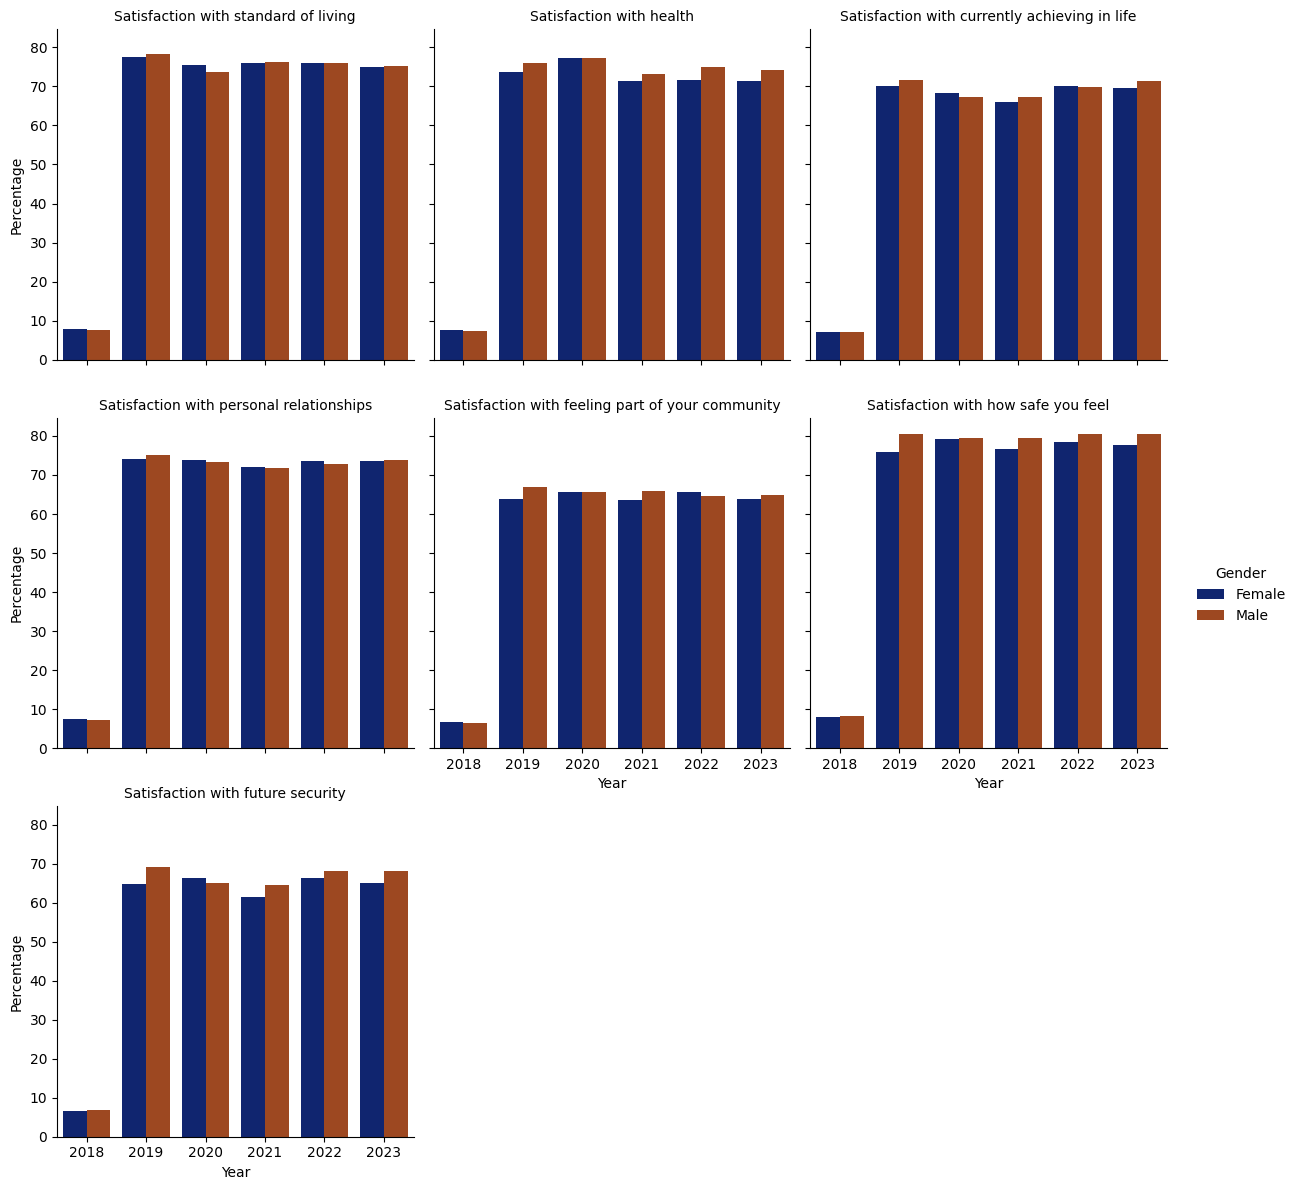

In [ ]:
def create_grouped_barplot_grid(dataframe):
    """
    Creates a grouped bar plot for gender by year for all subtopics in a grid layout.
    """

    # Filter data for 'Gender' category
    gender_data = dataframe[dataframe['Category'] == 'Gender']
    if gender_data.empty:
        print("No data found for the 'Gender' category.")
        return

    # Create a FacetGrid for subtopics
    g = sns.FacetGrid(
        gender_data,
        col="Subtopics",
        col_wrap=3,  # Number of plots per row
        height=4,
        sharey=True  # Share the same y-axis across plots
    )

    # Add bar plots to each facet with explicit palette
    g.map(
        sns.barplot,
        "year", "Percentage", "Subcategory",
        order=sorted(gender_data["year"].unique()),
        hue_order=sorted(gender_data["Subcategory"].unique()),
        palette="dark"  # Explicitly set the palette to avoid warnings
    )

    # Add legend and adjust layout
    g.add_legend(title="Gender")
    g.set_titles("{col_name}")
    g.set_axis_labels("Year", "Percentage")
    g.tight_layout()
    plt.show()

create_grouped_barplot_grid(processed_data)


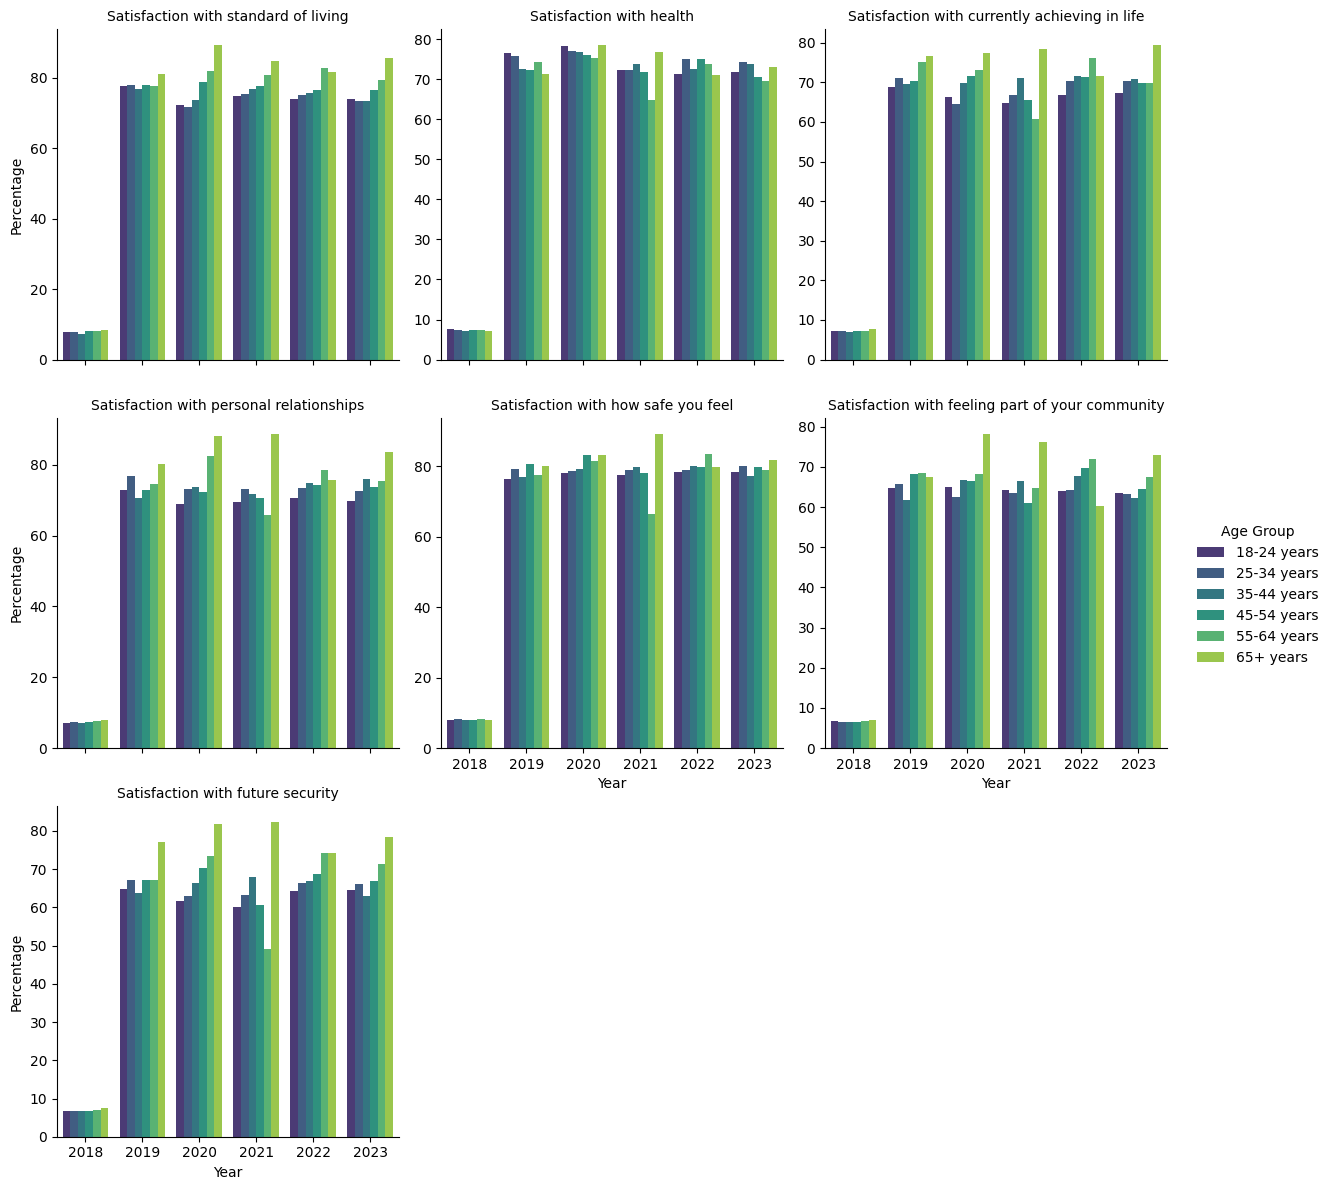

In [ ]:
# prompt: grouped barplot for Agegroup by year create for all subtopic  histogram Faceted Histogram Grid

def create_grouped_barplot_agegroup(dataframe):
    """
    Creates a grouped bar plot for Age Group by year for all subtopics.
    """

    # Filter data for 'Age Group' category
    agegroup_data = dataframe[dataframe['Category'] == 'Age Group']
    if agegroup_data.empty:
        print("No data found for the 'Age Group' category.")
        return

    # Create a FacetGrid for subtopics
    g = sns.FacetGrid(
        agegroup_data,
        col="Subtopics",
        col_wrap=3,  # Number of plots per row
        height=4,
        sharey=False  # Do not share the same y-axis across plots (for better visualization)
    )

    # Add bar plots to each facet
    g.map(
        sns.barplot,
        "year", "Percentage", "Subcategory",
        order=sorted(agegroup_data["year"].unique()),
        hue_order=sorted(agegroup_data["Subcategory"].unique()),
        palette="viridis" # Using viridis palette for better color distinction
    )

    # Add legend, titles, labels and adjust layout
    g.add_legend(title="Age Group")
    g.set_titles("{col_name}")
    g.set_axis_labels("Year", "Percentage")
    g.tight_layout()
    plt.show()

create_grouped_barplot_agegroup(processed_data)

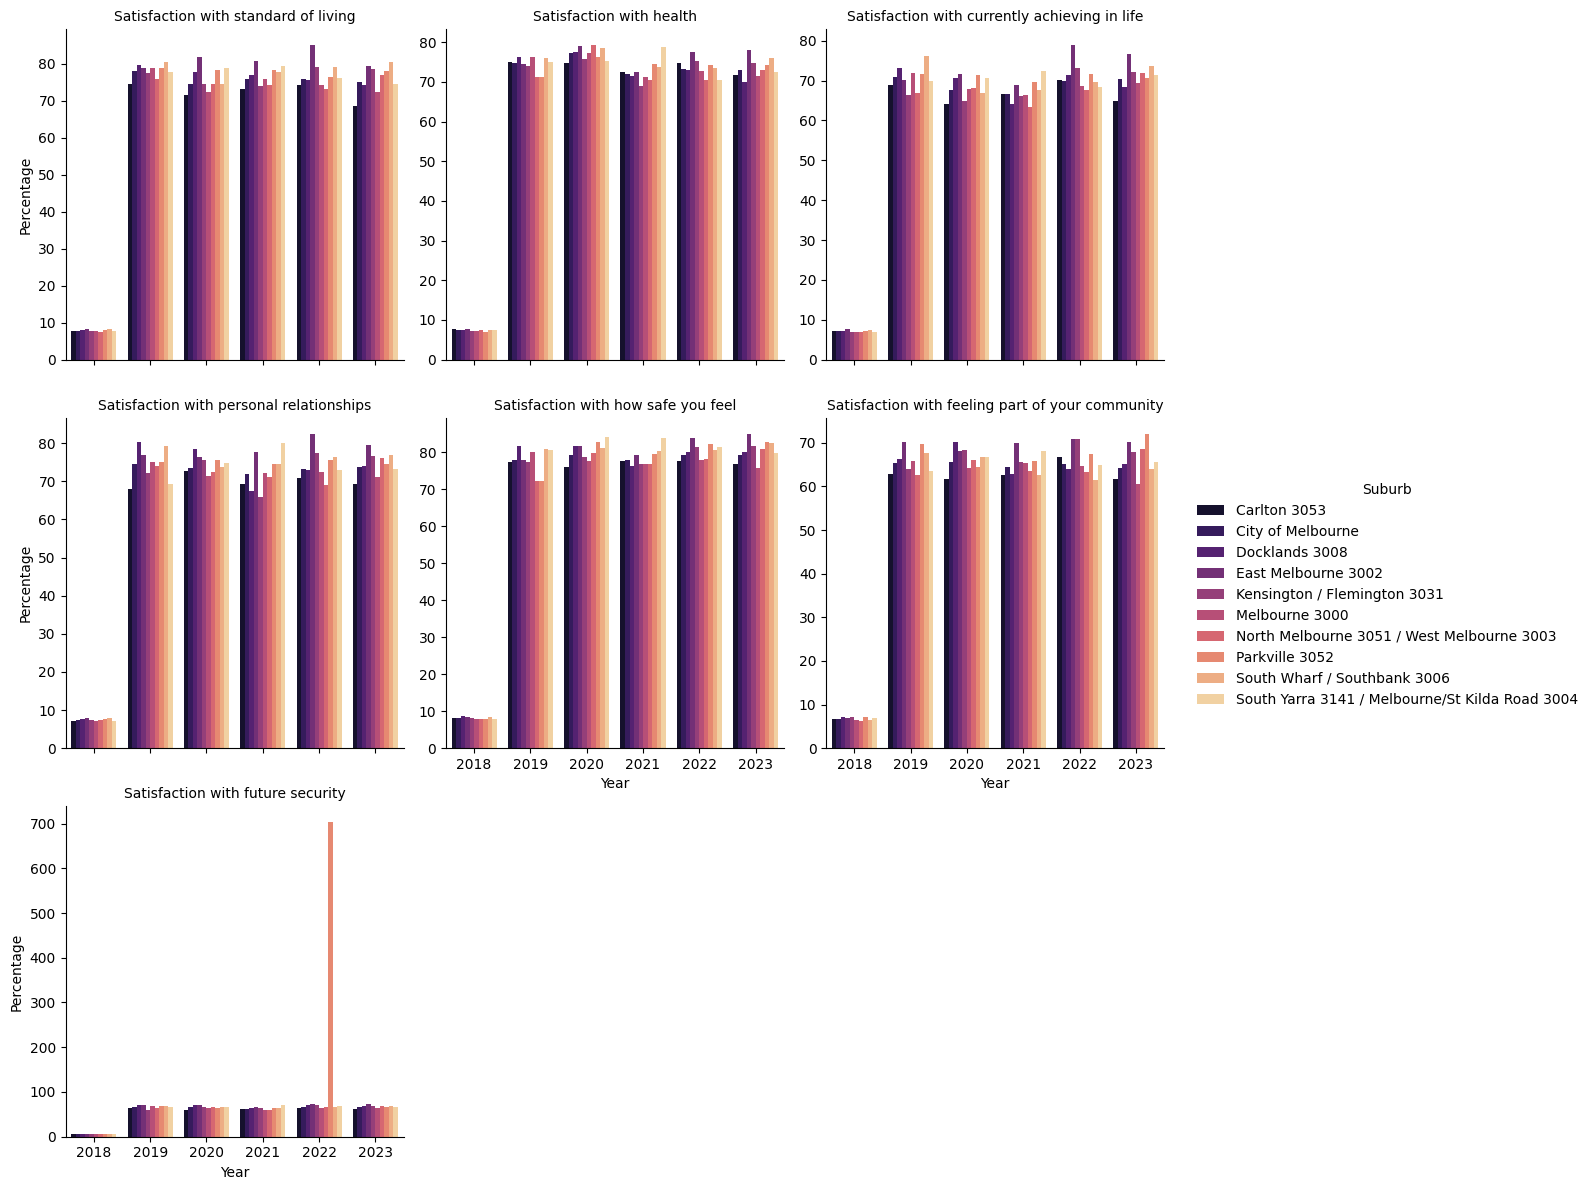

In [ ]:
# prompt: grouped plotfor surburb by year create for all subtopic  histogram Faceted Histogram Grid

def create_grouped_barplot_suburb(dataframe):
    """
    Creates a grouped bar plot for Suburb by year for all subtopics.
    """

    # Filter data for 'Suburb' category
    suburb_data = dataframe[dataframe['Category'] == 'Suburb']
    if suburb_data.empty:
        print("No data found for the 'Suburb' category.")
        return

    # Create a FacetGrid for subtopics
    g = sns.FacetGrid(
        suburb_data,
        col="Subtopics",
        col_wrap=3,  # Number of plots per row
        height=4,
        sharey=False  # Do not share the same y-axis across plots (for better visualization)
    )

    # Add bar plots to each facet
    g.map(
        sns.barplot,
        "year", "Percentage", "Subcategory",
        order=sorted(suburb_data["year"].unique()),
        hue_order=sorted(suburb_data["Subcategory"].unique()),
        palette="magma" # Using magma palette
    )

    # Add legend, titles, labels and adjust layout
    g.add_legend(title="Suburb")
    g.set_titles("{col_name}")
    g.set_axis_labels("Year", "Percentage")
    g.tight_layout()
    plt.show()

create_grouped_barplot_suburb(processed_data)

# **7. Geospatial Analysis**

In [ ]:
# prompt: filter surburb and  Add Latitude and Longitude Columns to the dataset according to the surburb

def add_lat_lon(df):
    """
    Adds latitude and longitude columns to the DataFrame based on the suburb.
    """
    geolocator = Nominatim(user_agent="geoapiExercises")

    # Create empty lists to store latitude and longitude
    latitudes = []
    longitudes = []

    # Iterate through the unique suburbs
    unique_suburbs = df['Subcategory'].unique()
    for suburb in tqdm(unique_suburbs, desc="Geocoding suburbs"):
        location = geolocator.geocode(suburb + ", Australia")  # Geocode with Australia as the country
        if location:
            latitudes.append(location.latitude)
            longitudes.append(location.longitude)
        else:
            latitudes.append(np.nan)
            longitudes.append(np.nan)
            print(f"Could not geocode suburb: {suburb}")


    # Create a dictionary to map suburbs to coordinates
    suburb_coordinates = dict(zip(unique_suburbs, zip(latitudes, longitudes)))

    # Add the latitude and longitude columns to the DataFrame
    df['Latitude'] = df['Subcategory'].map(lambda x: suburb_coordinates.get(x, (np.nan, np.nan))[0])
    df['Longitude'] = df['Subcategory'].map(lambda x: suburb_coordinates.get(x, (np.nan, np.nan))[1])

    return df


processed_data = add_lat_lon(processed_data)

Geocoding suburbs:  72%|███████▏  | 13/18 [00:08<00:02,  1.68it/s]

Could not geocode suburb: South Yarra 3141 / Melbourne/St Kilda Road 3004


Geocoding suburbs:  89%|████████▉ | 16/18 [00:10<00:01,  1.57it/s]

Could not geocode suburb: North Melbourne 3051 / West Melbourne 3003


Geocoding suburbs: 100%|██████████| 18/18 [00:13<00:00,  1.34it/s]


In [ ]:
# prompt:  verify that Latitude and Longitude columns have been added

# Verify if 'Latitude' and 'Longitude' columns exist
if 'Latitude' in processed_data.columns and 'Longitude' in processed_data.columns:
    print("Latitude and Longitude columns exist in the DataFrame.")

    # You can further check for NaN values if needed:
    nan_latitude_count = processed_data['Latitude'].isna().sum()
    nan_longitude_count = processed_data['Longitude'].isna().sum()
    print(f"Number of NaN values in Latitude: {nan_latitude_count}")
    print(f"Number of NaN values in Longitude: {nan_longitude_count}")
else:
    print("Latitude or Longitude columns are missing in the DataFrame.")

Latitude and Longitude columns exist in the DataFrame.
Number of NaN values in Latitude: 84
Number of NaN values in Longitude: 84


In [ ]:
# prompt:  Plotly Heatmap usinglatitude and longtitude

import plotly.graph_objects as go

def create_heatmap(dataframe, year, subtopic):
    """
    Creates a heatmap based on latitude, longitude, and percentage.
    """

    filtered_df = dataframe[(dataframe['year'] == year) & (dataframe['Subtopics'] == subtopic)]

    if filtered_df.empty:
        print(f"No data found for year {year} and subtopic '{subtopic}'.")
        return

    fig = go.Figure(data=go.Densitymapbox(
        lat=filtered_df['Latitude'],
        lon=filtered_df['Longitude'],
        z=filtered_df['Percentage'],
        radius=10,
        colorscale='Viridis', # Customize colorscale
        zmin=0,  # Set minimum z value
        zmax=100, # Set maximum z value
        showscale=True
    ))
    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": -33.8688, "lon": 151.2093}, # Center on Sydney, adjust as needed
        mapbox_zoom=8
    )
    fig.update_layout(title_text=f"Heatmap of {subtopic} in {year}", title_x=0.5) # Center the title
    fig.show()

# Example usage
create_heatmap(processed_data, 2023, "Satisfaction with health")

# Interactive heatmap with widgets
year_dropdown_heatmap = widgets.Dropdown(
    options=processed_data['year'].unique().tolist(),
    value=processed_data['year'].unique().tolist()[0],
    description='Year:',
)

subtopic_dropdown_heatmap = widgets.Dropdown(
    options=processed_data['Subtopics'].unique().tolist(),
    value=processed_data['Subtopics'].unique().tolist()[0],
    description='Subtopic:',
)

output_heatmap = widgets.Output()

def update_heatmap(change):
    with output_heatmap:
        clear_output(wait=True)
        create_heatmap(processed_data, year_dropdown_heatmap.value, subtopic_dropdown_heatmap.value)

year_dropdown_heatmap.observe(update_heatmap, names='value')
subtopic_dropdown_heatmap.observe(update_heatmap, names='value')


display(year_dropdown_heatmap, subtopic_dropdown_heatmap, output_heatmap)

with output_heatmap:
    create_heatmap(processed_data, year_dropdown_heatmap.value, subtopic_dropdown_heatmap.value)

Dropdown(description='Year:', options=(2023, 2022, 2020, 2019, 2018, 2021), value=2023)

Dropdown(description='Subtopic:', options=('Satisfaction with standard of living', 'Satisfaction with health',…

Output()

# **8. Interactive Mapping**

In [ ]:
# prompt: Suburb Satisfaction Map  focus

def create_interactive_map(dataframe, year, subtopic):
    """
    Creates an interactive map with markers for suburbs, colored by percentage.
    """

    filtered_df = dataframe[(dataframe['year'] == year) & (dataframe['Subtopics'] == subtopic)]

    if filtered_df.empty:
        print(f"No data found for year {year} and subtopic '{subtopic}'.")
        return

    # Find the average percentage for each suburb
    suburb_percentages = filtered_df.groupby('Subcategory')['Percentage'].mean()

    # Create a map centered on Sydney
    m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10)

    # Add markers for each suburb
    for suburb, percentage in suburb_percentages.items():
        latitude = filtered_df[filtered_df['Subcategory'] == suburb]['Latitude'].iloc[0]
        longitude = filtered_df[filtered_df['Subcategory'] == suburb]['Longitude'].iloc[0]

        if not pd.isna(latitude) and not pd.isna(longitude):  # Check for NaN values
            folium.CircleMarker(
                location=[latitude, longitude],
                radius=5,
                color='blue',  # Customize marker color
                fill=True,
                fill_color=plt.cm.viridis(percentage / 100), # Color based on percentage
                fill_opacity=0.7,
                popup=f"{suburb}: {percentage:.2f}%"
            ).add_to(m)

    return m


# Example usage
interactive_map = create_interactive_map(processed_data, 2023, "Satisfaction with health")
display(interactive_map)


# Interactive map with widgets
year_dropdown_map = widgets.Dropdown(
    options=processed_data['year'].unique().tolist(),
    value=processed_data['year'].unique().tolist()[0],
    description='Year:',
)

subtopic_dropdown_map = widgets.Dropdown(
    options=processed_data['Subtopics'].unique().tolist(),
    value=processed_data['Subtopics'].unique().tolist()[0],
    description='Subtopic:',
)


output_map = widgets.Output()

def update_map(change):
    with output_map:
      clear_output(wait=True)
      interactive_map = create_interactive_map(processed_data, year_dropdown_map.value, subtopic_dropdown_map.value)
      display(interactive_map)


year_dropdown_map.observe(update_map, names='value')
subtopic_dropdown_map.observe(update_map, names='value')

display(year_dropdown_map, subtopic_dropdown_map, output_map)


with output_map:
    interactive_map = create_interactive_map(processed_data, year_dropdown_map.value, subtopic_dropdown_map.value)
    display(interactive_map)

Dropdown(description='Year:', options=(2023, 2022, 2020, 2019, 2018, 2021), value=2023)

Dropdown(description='Subtopic:', options=('Satisfaction with standard of living', 'Satisfaction with health',…

Output()

# **9. Prediction Using Machine Learning**

In [ ]:
# prompt: Ensure the data is clean, with no missing or inconsistent values and display

# Assuming 'processed_data' DataFrame is already loaded and preprocessed.

# Check for missing values
display("Missing values in each column:")
display(processed_data.isnull().sum())

# Check for inconsistent data types (example: checking if 'year' is numeric)
if not pd.api.types.is_numeric_dtype(processed_data['year']):
    print("Warning: 'year' column is not numeric. Consider converting it.")
    # You can try converting to numeric if appropriate:
    # processed_data['year'] = pd.to_numeric(processed_data['year'], errors='coerce')  # 'coerce' will set invalid parsing to NaN
    # print(processed_data.isnull().sum())

# Check for inconsistencies in categorical columns (example: 'Category' and 'Subtopics')
for col in ['Category', 'Subtopics', 'Subcategory']:
    print(f"\nUnique values in '{col}' column:")
    print(processed_data[col].unique())

    # Example: Check for variations in capitalization or extra whitespace
    # processed_data[col] = processed_data[col].str.strip().str.lower() # convert to lowercase and remove whitespace


# Display the cleaned data
display(processed_data)

'Missing values in each column:'

,0
Subtopics,0
Category,0
Subcategory,0
year,0
Percentage,0
Latitude,0
Longitude,0



Unique values in 'Category' column:
['Age Group' 'Gender' 'Suburb']

Unique values in 'Subtopics' column:
['Satisfaction with standard of living' 'Satisfaction with health'
 'Satisfaction with currently achieving in life'
 'Satisfaction with personal relationships'
 'Satisfaction with how safe you feel'
 'Satisfaction with feeling part of your community'
 'Satisfaction with future security']

Unique values in 'Subcategory' column:
['35-44 years' '55-64 years' '65+ years' 'Female' 'Carlton 3053'
 'East Melbourne 3002' 'Kensington / Flemington 3031' 'Melbourne 3000'
 '45-54 years' 'City of Melbourne' 'Docklands 3008' 'Parkville 3052'
 'South Yarra 3141 / Melbourne/St Kilda Road 3004' '18-24 years' 'Male'
 'North Melbourne 3051 / West Melbourne 3003'
 'South Wharf / Southbank 3006' '25-34 years']


,Subtopics,Category,Subcategory,year,Percentage,Latitude,Longitude
142,Satisfaction with standard of living,Age Group,35-44 years,2023,73.4,-36.839942,143.707686
143,Satisfaction with standard of living,Age Group,55-64 years,2023,79.4,-36.839942,143.707686
144,Satisfaction with standard of living,Age Group,65+ years,2023,85.7,-36.839942,143.707686
145,Satisfaction with standard of living,Gender,Female,2023,74.9,-37.700802,145.020661
146,Satisfaction with standard of living,Suburb,Carlton 3053,2023,68.7,-37.800423,144.968434
...,...,...,...,...,...,...,...
3907,Satisfaction with future security,Age Group,35-44 years,2021,68.0,-36.839942,143.707686
3908,Satisfaction with future security,Age Group,65+ years,2021,82.3,-36.839942,143.707686
3909,Satisfaction with future security,Gender,Female,2021,61.5,-37.700802,145.020661
3910,Satisfaction with future security,Suburb,Melbourne 3000,2021,60.7,-37.814245,144.963173


In [ ]:
# prompt: Identify the columns to use as inputs (features) and the column to predict (target)

# Identify features (inputs) and target (prediction)
features = ['year', 'Category', 'Subtopics', 'Subcategory', 'Latitude', 'Longitude']  # Example features
target = 'Percentage'  # Example target variable


In [ ]:
# prompt: Split the data into training and testing datasets.

from sklearn.model_selection import train_test_split

# Assuming 'processed_data' DataFrame is already loaded and preprocessed.

# Separate features (X) and target (y)
X = processed_data[features]
y = processed_data[target]

# Convert categorical features to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['Category', 'Subtopics', 'Subcategory'], drop_first=True)

# Handle missing values (if any) - Impute with mean for numerical features and mode for categorical
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
      X[col].fillna(X[col].mean(),inplace=True)
    else:
      X[col].fillna(X[col].mode()[0], inplace = True)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

# Now you can use X_train, X_test, y_train, and y_test for training and evaluating your machine learning model.
print("Training data shapes:", X_train.shape, y_train.shape)
print("Testing data shapes:", X_test.shape, y_test.shape)

Training data shapes: (604, 28) (604,)
Testing data shapes: (152, 28) (152,)


<ipython-input-45-01de90012b4e>:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [ ]:
# prompt: A more robust model for handling non-linear relationships.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# You can further improve the model by:
# 1. Hyperparameter tuning (using GridSearchCV or RandomizedSearchCV)
# 2. Feature engineering (creating new features or transforming existing ones)
# 3. Trying different models (e.g., Gradient Boosting, Support Vector Regression)

# Example of predicting for new data:
# Create a new data point with the same features as in the training data.
# new_data_point = pd.DataFrame({
#     'year': [2024],
#     'Category_Gender': [0],  # Assuming 'Gender'
#     'Subtopics_Satisfaction with health': [1],
#     'Subcategory_Female': [0], # Assuming 'Female'
#     'Latitude': [-33.8688],
#     'Longitude': [151.2093],
#     # ... other features ...
# })
# # ensure to get dummies for your new data point
# new_data_point = pd.get_dummies(new_data_point, columns=['Category', 'Subtopics', 'Subcategory'], drop_first=True)
# # Ensure that the columns in new_data_point exactly match the columns of X_train.
# for col in X_train.columns:
#   if col not in new_data_point.columns:
#     new_data_point[col] = 0
# for col in new_data_point.columns:
#   if col not in X_train.columns:
#     new_data_point.drop(col, axis=1,inplace = True)

# new_prediction = model.predict(new_data_point)

# print(f"Prediction for new data point: {new_prediction}")

Mean Squared Error: 9.132876842105224
R-squared: 0.9848960275500553


In [ ]:
# prompt: Predict satisfaction levels for 2024, 2025,2026

import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Assuming 'processed_data', 'features', 'target', 'X', and 'model' are defined from the previous code.

def predict_satisfaction(model, features, years_to_predict):
    """Predicts satisfaction levels for specified years.

    Args:
        model: The trained RandomForestRegressor model.
        features: A list of feature names.
        years_to_predict: A list of years to predict.
    """
    predictions = {}

    for year in years_to_predict:

        for category in processed_data['Category'].unique():
          for subtopic in processed_data['Subtopics'].unique():
            for subcategory in processed_data['Subcategory'].unique():
              new_data_point = pd.DataFrame({
                  'year': [year],
                  'Category': [category],
                  'Subtopics': [subtopic],
                  'Subcategory': [subcategory],
                  'Latitude': [processed_data['Latitude'].mean()], # Using the mean as a placeholder
                  'Longitude': [processed_data['Longitude'].mean()]  # Using the mean as a placeholder
                  })
              new_data_point = pd.get_dummies(new_data_point, columns=['Category', 'Subtopics', 'Subcategory'], drop_first=True)

              # Align columns
              for col in X.columns:
                  if col not in new_data_point.columns:
                      new_data_point[col] = 0
              for col in new_data_point.columns:
                  if col not in X.columns:
                      new_data_point.drop(col, axis=1, inplace=True)

              prediction = model.predict(new_data_point)[0]

              key = f"{year}_{category}_{subtopic}_{subcategory}"
              predictions[key] = prediction

    return predictions
# Example usage
years_to_predict = [2024, 2025, 2026]
predicted_satisfaction = predict_satisfaction(model, features, years_to_predict)

for key, value in predicted_satisfaction.items():
    year, category, subtopic, subcategory = key.split("_")
    print(f"Predicted satisfaction for {year} : {category} - {subtopic} - {subcategory}: {value}")

Predicted satisfaction for 2024 : Age Group - Satisfaction with standard of living - 35-44 years: 69.47199999999997
Predicted satisfaction for 2024 : Age Group - Satisfaction with standard of living - 55-64 years: 69.47199999999997
Predicted satisfaction for 2024 : Age Group - Satisfaction with standard of living - 65+ years: 69.47199999999997
Predicted satisfaction for 2024 : Age Group - Satisfaction with standard of living - Female: 69.47199999999997
Predicted satisfaction for 2024 : Age Group - Satisfaction with standard of living - Carlton 3053: 69.47199999999997
Predicted satisfaction for 2024 : Age Group - Satisfaction with standard of living - East Melbourne 3002: 69.47199999999997
Predicted satisfaction for 2024 : Age Group - Satisfaction with standard of living - Kensington / Flemington 3031: 69.47199999999997
Predicted satisfaction for 2024 : Age Group - Satisfaction with standard of living - Melbourne 3000: 69.47199999999997
Predicted satisfaction for 2024 : Age Group - Sati

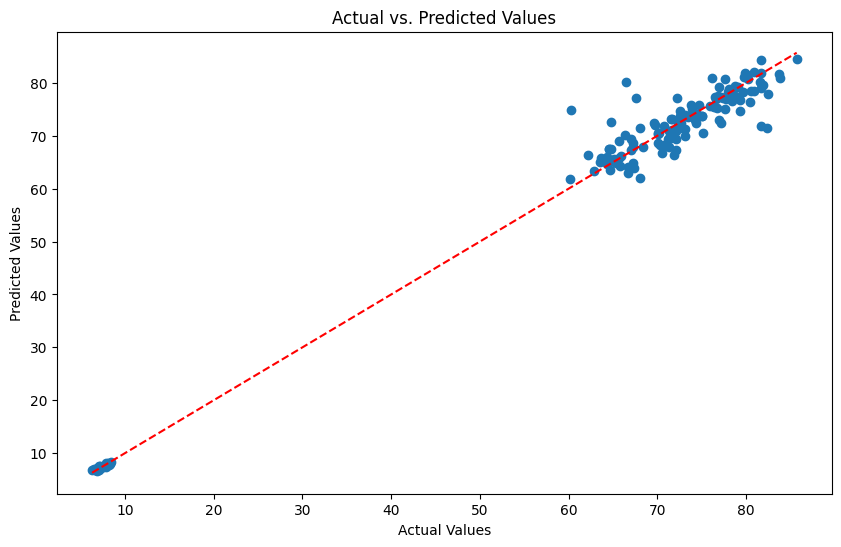

In [ ]:
# prompt: Plot the actual vs. predicted values to evaluate the model visually.

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # Add a diagonal line
plt.show()